In [ ]:

!pip install tensorflow

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Using cached tensorflow-2.15.0.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
  Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
  Using cached gast-0.5.4-py3-none-any.whl (19 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl (7.7 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Using cached tensorflow_io_gcs_filesystem-0.36.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.1 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached ml_dtypes-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
  Using cached h5py-3.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.8 MB)
  Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl (441 kB)
  

### Non Linear Compressor Class (NTC)

- The standard normal distribution will be used to test the class before the full implementation with poitncloud data

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# https://www.tensorflow.org/guide/basic_training_loops
class NonLinearCompressor:
    def __init__(self, lambda_= 0):
        self.lambda_ = lambda_
        self.optimizer = optimizers.Adam()
        self.build_forward_transform()
        self.build_inverse_transform()

        self.distortion = []
        self.rate = []


    def build_forward_transform(self):
        self.forward_transform = models.Sequential()
        self.forward_transform.add(layers.Dense(16, activation='relu', input_shape=(1,)))
        self.forward_transform.add(layers.Dense(16, activation='relu'))
        self.forward_transform.add(layers.Dense(1))
        self.forward_transform.add(layers.LeakyReLU())


    def build_inverse_transform(self):
        self.inverse_transform = models.Sequential()
        self.inverse_transform.add(layers.Dense(16, activation='relu', input_shape=(1,)))
        self.inverse_transform.add(layers.Dense(16, activation='relu'))
        self.inverse_transform.add(layers.Dense(1))
        self.inverse_transform.add(layers.LeakyReLU())


    def continuous_quantizer(self, x):
        # adding noise to input 
        noise = tf.random.uniform(tf.shape(x), minval=-1/2, maxval=1/2)
        return x + noise 
    
    def discrete_quantizer(self, data):
        # floors input data after adding 0.5 to all values
        return np.floor(data + 0.5)
    
    def lossless_coder(self, data, mu=0, sigma=1):
        mu = tf.constant(mu, dtype=tf.float32)
        sigma = tf.constant(sigma, dtype=tf.float32)
        pi = tf.constant(np.pi, dtype=tf.float32)

        # trying to change pdf here 
        return -tf.math.log((1.0 / (tf.sqrt(2.0 * pi * tf.square(sigma)))) * 
                            tf.exp(-tf.square(data - mu) / (2.0 * tf.square(sigma))))

    @tf.function
    def train_step(self, x_train):
        with tf.GradientTape() as tape:
            x_transformed = self.forward_transform(x_train)
            x_quantized = self.continuous_quantizer(x_transformed)
            x_hat = self.inverse_transform(x_quantized)

            distortion = tf.reduce_mean(tf.square(x_train - x_hat))
            rate = tf.reduce_mean(self.lossless_coder(x_quantized))

            loss = distortion + self.lambda_ * rate

        gradients = tape.gradient(loss, self.forward_transform.trainable_variables + self.inverse_transform.trainable_variables)   
        self.optimizer.apply_gradients(zip(gradients, self.forward_transform.trainable_variables + self.inverse_transform.trainable_variables))
        return loss
    
    def get_batches(self, data, batch_size):
        for i in range(0, len(data), batch_size):
            yield data[i:i + batch_size]

    def train(self, x_train, x_val, epochs=10, batch_size=32):

        history = {
            'loss': [],
            'val_loss': [],
        }

        x_train = x_train.reshape(-1, 1).astype('float32')
        x_val = x_val.reshape(-1, 1).astype('float32')

        for epoch in range(epochs):
            train_loss = 0
            for batch in self.get_batches(x_train, batch_size):
                train_loss += self.train_step(batch).numpy()
            train_loss /= len(x_train) / batch_size
            history['loss'].append(train_loss)

            _, val_loss = self.evaluate(x_val, True)
            history['val_loss'].append(val_loss)

            print(f"Epoch {epoch+1}, Loss: {train_loss}, Validation Loss: {val_loss}")

        return history


    def evaluate(self, x_test, training=0):
        x_test = x_test.reshape(-1, 1).astype('float32')

        x_transformed = self.forward_transform(x_test)
        x_quantized = self.discrete_quantizer(x_transformed)
        x_hat = self.inverse_transform(x_quantized)
        
        distortion = tf.reduce_mean(tf.square(x_test - x_hat))
        self.distortion.append(distortion)
        
        # rate = tf.reduce_mean(self.lossless_coder(x_quantized)) # deduce pmf then compute its entropy to determine rate. 
        _, _, count = tf.unique_with_counts(tf.reshape(x_quantized, [-1]))
        total_elements = tf.cast(tf.size(x_quantized), tf.float32)
        pmf = tf.cast(count, tf.float32) / total_elements

        # Filtering out probabilities that are greater than zero
        pmf = pmf[pmf > 0]

        # Calculating entropy using TensorFlow operations
        rate = -tf.reduce_sum(pmf * tf.math.log(pmf) / tf.math.log(2.0))

        if not training:
            self.distortion.append(distortion)
            self.rate.append(rate)


        loss = distortion + self.lambda_ * rate
        return x_hat.numpy(), loss.numpy()

In [ ]:

def run_experiments():
    results = {}

    for l in lambdas:
        print(f"Running experiment with λ={l}")
                
        model = NonLinearCompressor(lambda_ = l)
        # model = NonLinearCompressor(k=1, m=1,lambda_ = l)
        x_train = np.random.standard_normal((50000, 1)).astype('float32')
        x_val = np.random.standard_normal((50000 // 10, 1)).astype('float32')   # 10% for validation
        history = model.train(x_train, x_val, 4, 64)                            # epochs, batch_size
        x_reconstructed = model.evaluate(x_val)
        results[l] = (x_val, x_reconstructed, history['val_loss'], model.rate, model.distortion)

    return results


lambdas = [0.005, 0.05, 0.1,0.5,1,2,3,3.1,4,5]
results = run_experiments()


Running experiment with λ=0.005
Epoch 1, Loss: 0.22339093769073487, Validation Loss: 0.03261576592922211
Epoch 2, Loss: 0.03385233009338379, Validation Loss: 0.031332481652498245
Epoch 3, Loss: 0.03358220345973968, Validation Loss: 0.03130317106842995
Epoch 4, Loss: 0.03383494730949402, Validation Loss: 0.031234774738550186
Running experiment with λ=0.05
Epoch 1, Loss: 0.27162402919769285, Validation Loss: 0.16986176371574402
Epoch 2, Loss: 0.13772205368041993, Validation Loss: 0.1684560477733612
Epoch 3, Loss: 0.1367926558303833, Validation Loss: 0.16844189167022705
Epoch 4, Loss: 0.13726975640296937, Validation Loss: 0.16904860734939575
Running experiment with λ=0.1
Epoch 1, Loss: 0.35747441692352294, Validation Loss: 0.28621023893356323
Epoch 2, Loss: 0.2218445495605469, Validation Loss: 0.28627240657806396
Epoch 3, Loss: 0.22134938997268677, Validation Loss: 0.28657448291778564
Epoch 4, Loss: 0.22155144023895262, Validation Loss: 0.2881752550601959
Running experiment with λ=0.5
Epo

### Original vs Reconstructed Data
- Note: Increasing Lambda appropriately descreases code rate (# of orange pillars)

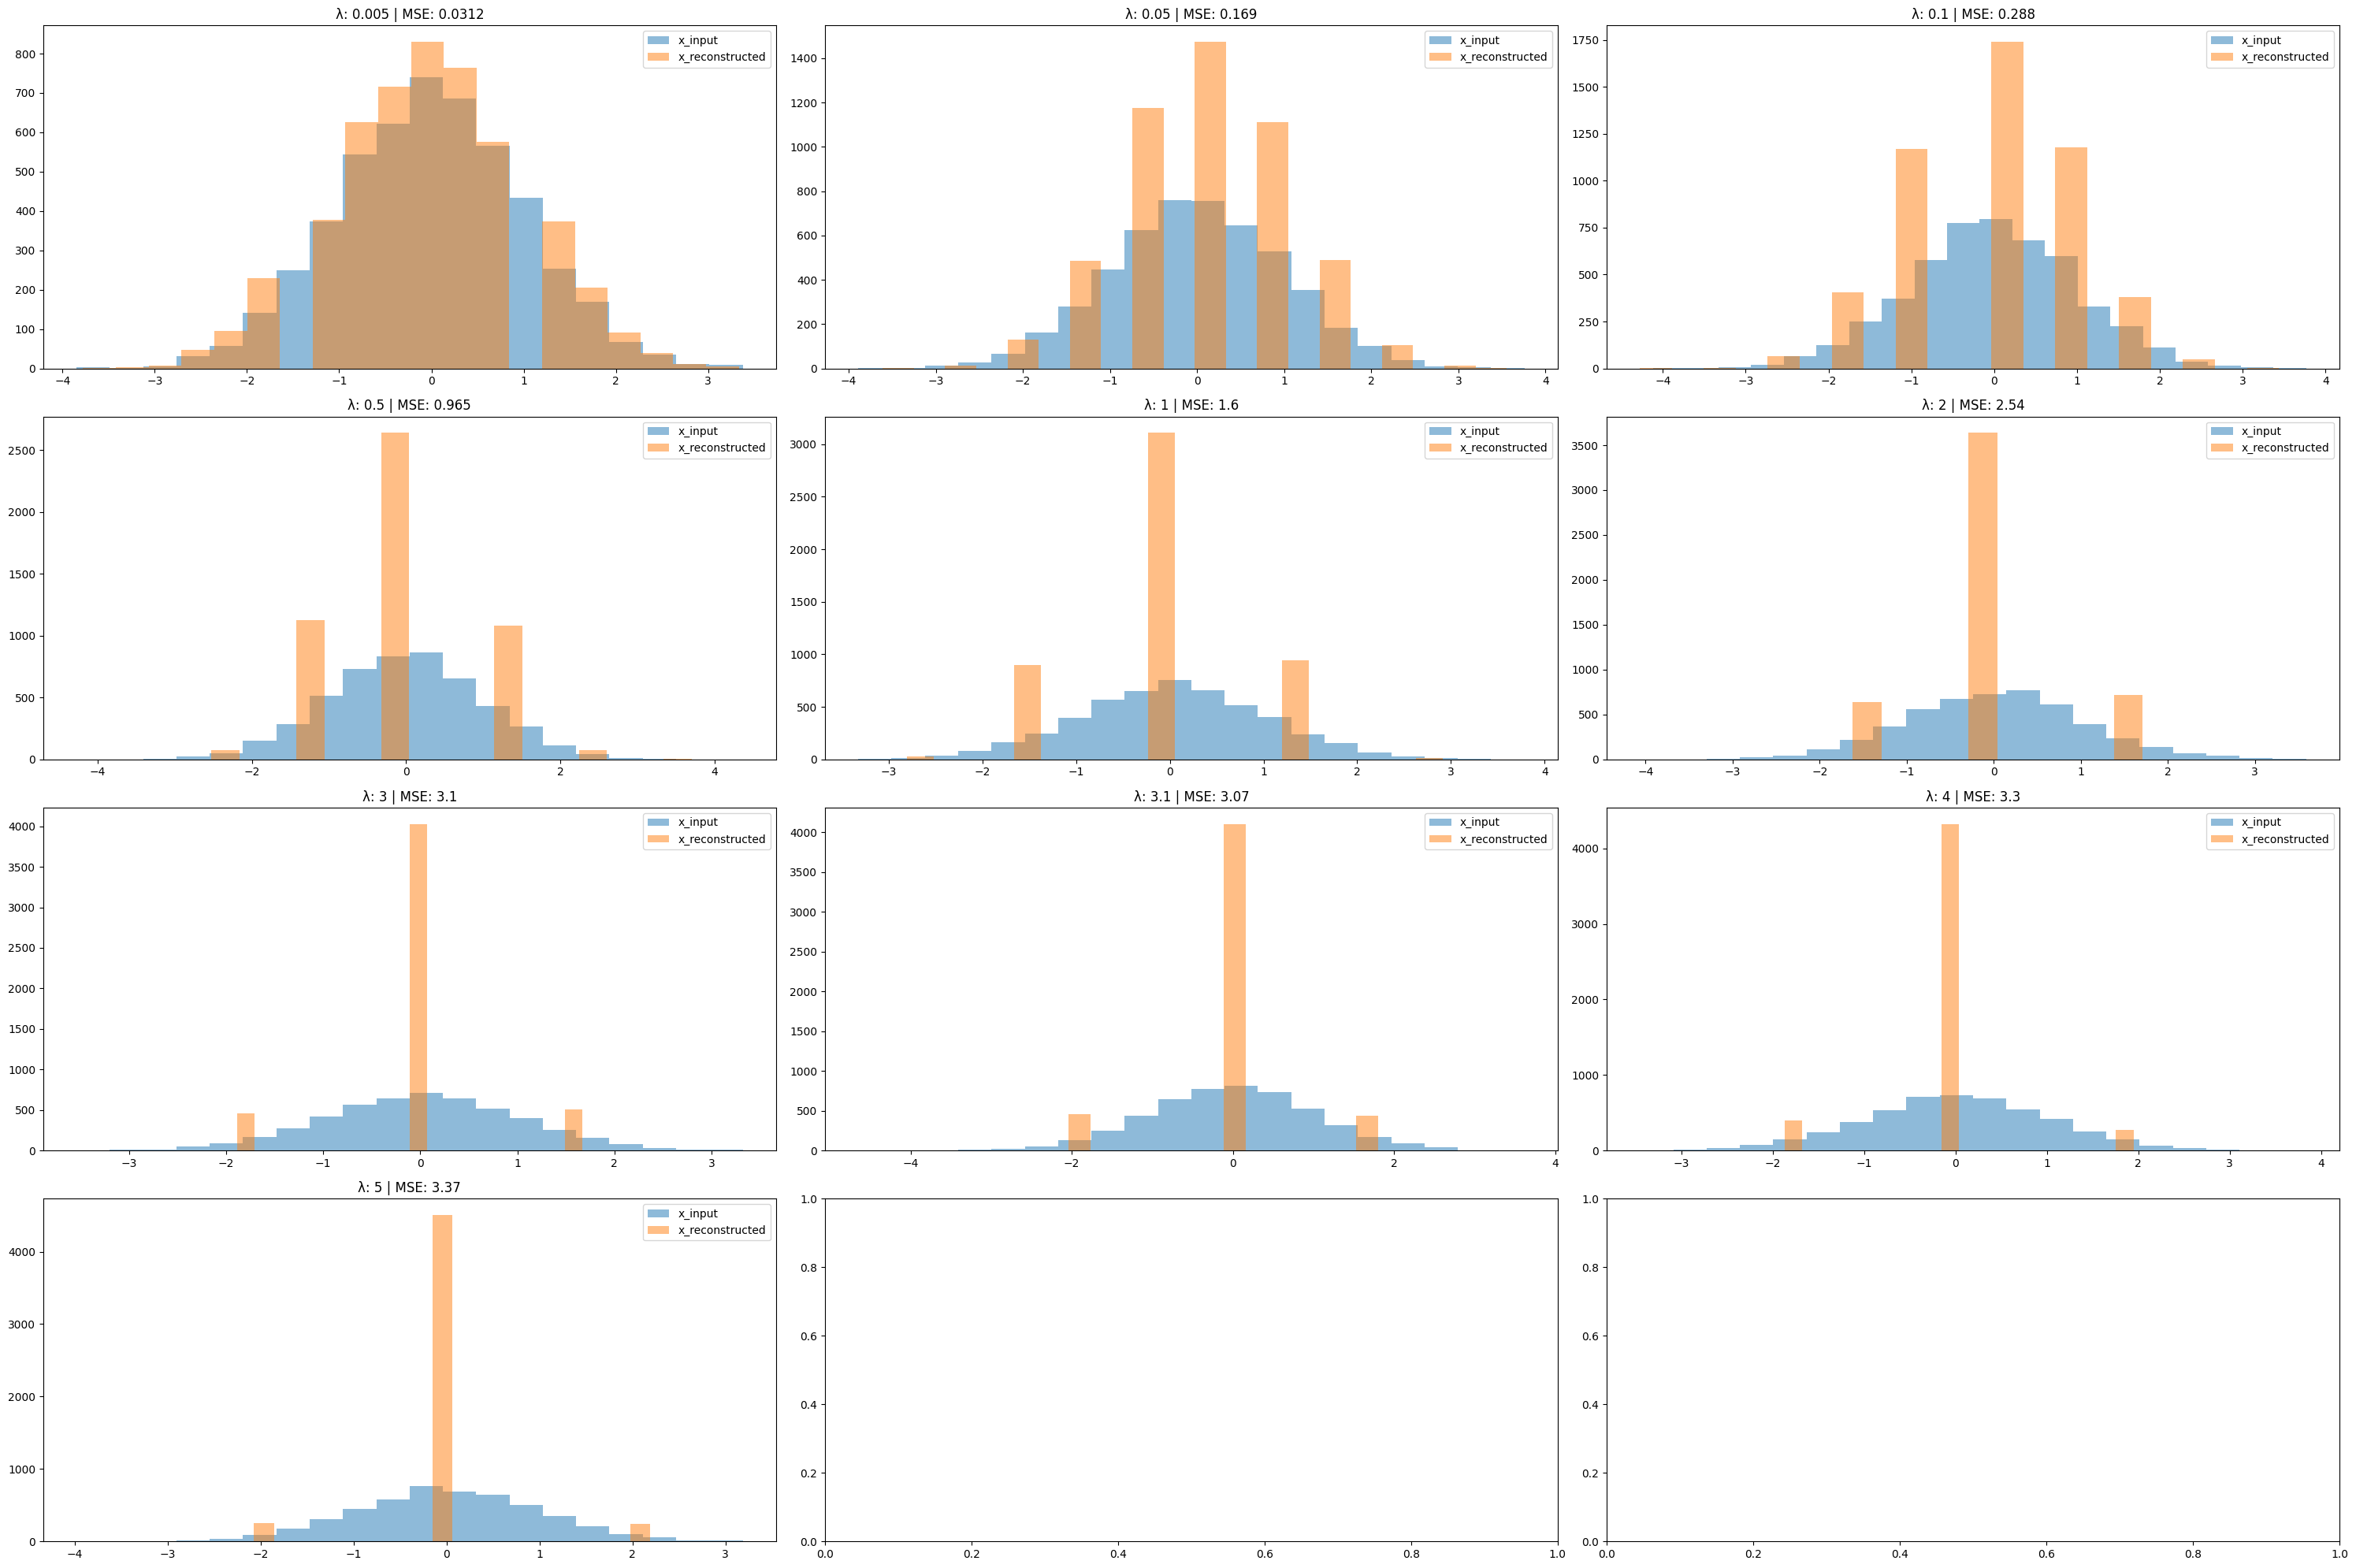

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num_cols = 3
num_rows = int(np.ceil(len(results) / 3))
num_subplots = num_rows * num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10*num_cols, 5*num_rows))

for i, (lambda_key, (x_input, x_reconstructed, *_)) in enumerate(results.items()):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]

    ax.hist(x_input, bins=20, alpha=0.5, label='x_input')
    ax.hist(x_reconstructed[0], bins=20, alpha=0.5, label='x_reconstructed')
    ax.set_title(f'λ: {lambda_key} | MSE: {x_reconstructed[1]:.3}')
    ax.legend()

plt.tight_layout()
plt.show()

### Lloyd Max Comparison


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def lloyd_max_quantizer(samples, N=10, max_iter=1000, tol=1e-5):
    # Initialize quantization levels
    min_val, max_val = min(samples), max(samples)
    quant_levels = np.linspace(min_val, max_val, N)

    for _ in range(max_iter):
        # Update decision boundaries (bin edges)
        bins = np.empty(N+1)
        bins[0], bins[-1] = min_val, max_val
        bins[1:-1] = 0.5 * (quant_levels[:-1] + quant_levels[1:])

        # Quantize samples based on updated bins
        digitized = np.digitize(samples, bins) - 1  # Adjust for zero-based indexing

        # Ensure no index exceeds the length of quant_levels
        digitized = np.minimum(digitized, len(quant_levels) - 1)

        new_quant_levels = np.array([samples[digitized == i].mean() if np.any(digitized == i) else quant_levels[i] for i in range(N)])

        # Check for convergence
        if np.linalg.norm(new_quant_levels - quant_levels) < tol:
            break
        quant_levels = new_quant_levels

    # Map each sample to its quantization level
    quantized_samples = quant_levels[digitized]

    # return quantized_samples, quant_levels
    return quantized_samples

data = np.random.normal(0, 1, 8000)  
quantization_levels = [2, 4, 8, 16, 32, 64]  # rate = log_2(level)

rates = []
distortions = []

for level in quantization_levels:

    quantized_data = lloyd_max_quantizer(data, N=level)

    distortion = np.mean((data - quantized_data) ** 2)
    distortions.append(distortion)

    rate = np.log2(level)
    rates.append(rate)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_metrics(metrics_dict, rates, distortions):
    fig = make_subplots(rows=1, cols=3, subplot_titles=("NonLinearCompressor", "Lloyd-Max Quantizer", "Combined"))

    # Collecting data for the third plot
    combined_rates = []
    combined_distortions = []

    # FIRST PLOT
    for lambda_, (_, _, _, rate, distortion) in metrics_dict.items():
        avg_rate = sum(rate) / len(rate)
        avg_distortion = sum(distortion) / len(distortion)
        combined_rates.append(avg_rate)
        combined_distortions.append(avg_distortion)
        fig.add_trace(go.Scatter(
            x=[avg_rate], 
            y=[avg_distortion], 
            mode='markers', 
            name=f'λ={lambda_}',
            customdata=[lambda_],
            hovertemplate='λ: %{customdata}<br>Rate: %{x:.2f}<br>Distortion: %{y:.2f}<extra></extra>',
            showlegend=False
        ), row=1, col=1)

    # SECOND PLOT
    fig.add_trace(go.Scatter(
        x=rates, 
        y=distortions, 
        mode='markers',  
        name='Lloyd',
        hovertemplate='Rate: %{x:.2f}<br>Distortion: %{y:.2f}<extra></extra>',
        showlegend=False
    ), row=1, col=2)

    # THIRD PLOT - Combined
    # NonLinearCompressor data
    fig.add_trace(go.Scatter(
        x=combined_rates, 
        y=combined_distortions, 
        mode='lines+markers', 
        name='NonLinearCompressor',
        line=dict(shape='spline'),
        hovertemplate='Rate: %{x:.2f}<br>Distortion: %{y:.2f}<extra></extra>'
    ), row=1, col=3)

    # Lloyd-Max data
    fig.add_trace(go.Scatter(
        x=rates, 
        y=distortions, 
        mode='lines+markers',
        name='Lloyd-Max',
        line=dict(shape='spline'),
        hovertemplate='Rate: %{x:.2f}<br>Distortion: %{y:.2f}<extra></extra>'
    ), row=1, col=3)

    # LAYOUT 
    fig.update_layout(
        title="Comparison of Rate-Distortion Curves",
        height=600, width=1800  
    )

    fig.update_xaxes(dtick=1, row=1, col=2)
    fig.update_xaxes(dtick=1, row=1, col=3)
    for i in range(1, 4):
        fig.update_xaxes(title_text="Rate", row=1, col=i)
        fig.update_yaxes(title_text="Distortion", row=1, col=i)

    fig.show()

# Example usage
plot_metrics(results, rates, distortions)

### X^k Length Block Codes

- Block codes will be used to experiment with how assumptions about the lossless decoder effect reconstruction accuracy

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers


# Rate calcualted across all m's
# New pmf calculation method

class NonLinearCompressor:
    def __init__(self, k, m, lambda_= 0):
        self.k = k  # Number of input dimensions
        self.m = m  # Number of output dimensions
        self.lambda_ = lambda_
        self.optimizer = optimizers.Adam()
        self.build_forward_transform()
        self.build_inverse_transform()

        self.distortion = []
        self.rate = []

    def build_forward_transform(self):
        self.forward_transform = models.Sequential()
        self.forward_transform.add(layers.Dense(16, activation='relu', input_shape=(self.k,)))
        self.forward_transform.add(layers.Dense(16, activation='relu'))
        self.forward_transform.add(layers.Dense(self.m))  # Output m values
        self.forward_transform.add(layers.LeakyReLU())

    def build_inverse_transform(self):
        self.inverse_transform = models.Sequential()
        self.inverse_transform.add(layers.Dense(16, activation='relu', input_shape=(self.m,)))
        self.inverse_transform.add(layers.Dense(16, activation='relu'))
        self.inverse_transform.add(layers.Dense(self.k))  # Output k values
        self.inverse_transform.add(layers.LeakyReLU())

    def continuous_quantizer(self, x):
        noise = tf.random.uniform(tf.shape(x), minval=-1/2, maxval=1/2)
        return x + noise 

    def discrete_quantizer(self, data):
        return np.floor(data + 0.5)

    def lossless_coder(self, data, mu=0, sigma=1):
        mu = tf.constant(mu, dtype=tf.float32)
        sigma = tf.constant(sigma, dtype=tf.float32)
        pi = tf.constant(np.pi, dtype=tf.float32)

        # product of individual q's over all m's before taking log, or sum over all log for every m
        # use different functions with more parametrs, or normal distributions with different varainces for every q_j, j=1,...,m
        # compute sigma_j at most every batch
        # PSNR instead of distortion maybe
        return -tf.math.log((1.0 / (tf.sqrt(2.0 * pi * tf.square(sigma)))) * 
                            tf.exp(-tf.square(data - mu) / (2.0 * tf.square(sigma))))
        
    
    @tf.function
    def train_step(self, x_train):
        with tf.GradientTape() as tape:
            x_transformed = self.forward_transform(x_train)
            x_quantized = self.continuous_quantizer(x_transformed)
            x_hat = self.inverse_transform(x_quantized)

            distortion = tf.reduce_mean(tf.square(x_train - x_hat))
            
            # return array, instead of taking mean introduce new pmf on self.lossless_coder(x_quantized)
            rate = tf.reduce_mean(self.lossless_coder(x_quantized))     

            loss = distortion + self.lambda_ * rate

        gradients = tape.gradient(loss, self.forward_transform.trainable_variables + self.inverse_transform.trainable_variables)   
        self.optimizer.apply_gradients(zip(gradients, self.forward_transform.trainable_variables + self.inverse_transform.trainable_variables))
        return loss
    
    def get_batches(self, data, batch_size):
        for i in range(0, len(data), batch_size):
            yield data[i:i + batch_size]

    def train(self, x_train, x_val, epochs=10, batch_size=32):

        history = {
            'loss': [],
            'val_loss': [],
        }

        x_train = x_train.reshape(-1, self.k).astype('float32')
        x_val = x_val.reshape(-1, self.k).astype('float32')

        for epoch in range(epochs):
            train_loss = 0
            for batch in self.get_batches(x_train, batch_size):
                train_loss += self.train_step(batch).numpy()
            train_loss /= len(x_train) / batch_size
            history['loss'].append(train_loss)

            _, val_loss = self.evaluate(x_val, True)
            history['val_loss'].append(val_loss)

            print(f"Epoch {epoch+1}, Loss: {train_loss}, Validation Loss: {val_loss}")

        return history

    def evaluate(self, x_test, training=0):
        x_test = x_test.reshape(-1, self.k).astype('float32')

        x_transformed = self.forward_transform(x_test)
        x_quantized = self.discrete_quantizer(x_transformed)
        x_hat = self.inverse_transform(x_quantized)
        
        distortion = tf.reduce_mean(tf.square(x_test - x_hat))
        self.distortion.append(distortion)
        
        rate = tf.reduce_mean(self.lossless_coder(x_quantized)) # deduce pmf then compute its entropy to determine rate. 

        if not training:
            self.distortion.append(distortion)
            self.rate.append(rate)


        loss = distortion + self.lambda_ * rate
        return x_hat.numpy(), loss.numpy()

In [ ]:
import numpy as np


def generate_covariance_matrix(k):
    A = np.random.rand(k, k)  # Generate a k x k matrix with random numbers
    matrix = np.dot(A, A.T)  # Multiply the matrix by its transpose to ensure positive semi-definiteness
    matrix /= np.max(matrix)  # Normalize to ensure values are between 0 and 1
    np.fill_diagonal(matrix, 1)  # Set diagonal elements to 1
    
    # Adjust off-diagonal elements to be less than 1
    for i in range(k):
        for j in range(k):
            if i != j:
                matrix[i, j] = matrix[i, j] * 0.9  # Scale down off-diagonal elements

    return matrix

n = 50000
def run_experiments():
    results = {}

    for k,m in km_pair:
        print(f"Running experiment with k={k}, m={m}")
                
        model = NonLinearCompressor(k=k, m=m, lambda_ = 3)

        covariance_matrix = generate_covariance_matrix(k)
        x_train = np.random.multivariate_normal(mean=np.zeros(k), cov=covariance_matrix, size= n).astype('float32')
        x_val = np.random.multivariate_normal(mean=np.zeros(k), cov=covariance_matrix, size= n //10 ).astype('float32')
        history = model.train(x_train, x_val, 4, 64)                            

        x_reconstructed = model.evaluate(x_val)
        results[(k,m)] = (x_val, x_reconstructed, covariance_matrix,history['val_loss'], model.rate, model.distortion)

    return results


km_pair = [(3,1), (6,2), (6,3),(6,4),(9,4)]
results = run_experiments()


Running experiment with k=3, m=1
Epoch 1, Loss: 3.7832305731201172, Validation Loss: 3.653280019760132
Epoch 2, Loss: 3.6802457510375977, Validation Loss: 3.6448140144348145
Epoch 3, Loss: 3.677192182006836, Validation Loss: 3.6471235752105713
Epoch 4, Loss: 3.6752746072387694, Validation Loss: 3.643649101257324
Running experiment with k=6, m=2
Epoch 1, Loss: 3.804693098754883, Validation Loss: 3.6289730072021484
Epoch 2, Loss: 3.696760556945801, Validation Loss: 3.623678684234619
Epoch 3, Loss: 3.695701884460449, Validation Loss: 3.6248059272766113
Epoch 4, Loss: 3.6953249871826173, Validation Loss: 3.622694253921509
Running experiment with k=6, m=3
Epoch 1, Loss: 3.665188755493164, Validation Loss: 3.48447847366333
Epoch 2, Loss: 3.5628578518676757, Validation Loss: 3.4842422008514404
Epoch 3, Loss: 3.5608432431030272, Validation Loss: 3.480717658996582
Epoch 4, Loss: 3.551226620788574, Validation Loss: 3.492246389389038
Running experiment with k=6, m=4
Epoch 1, Loss: 3.6896988619995

In [ ]:
np.set_printoptions(precision=3, suppress=True)
print(corr_matrix)

[[1.    0.538 0.581 0.581 0.324 0.456]
 [0.538 1.    0.624 0.668 0.363 0.536]
 [0.581 0.624 1.    0.608 0.371 0.603]
 [0.581 0.668 0.608 1.    0.324 0.6  ]
 [0.324 0.363 0.371 0.324 1.    0.345]
 [0.456 0.536 0.603 0.6   0.345 1.   ]]


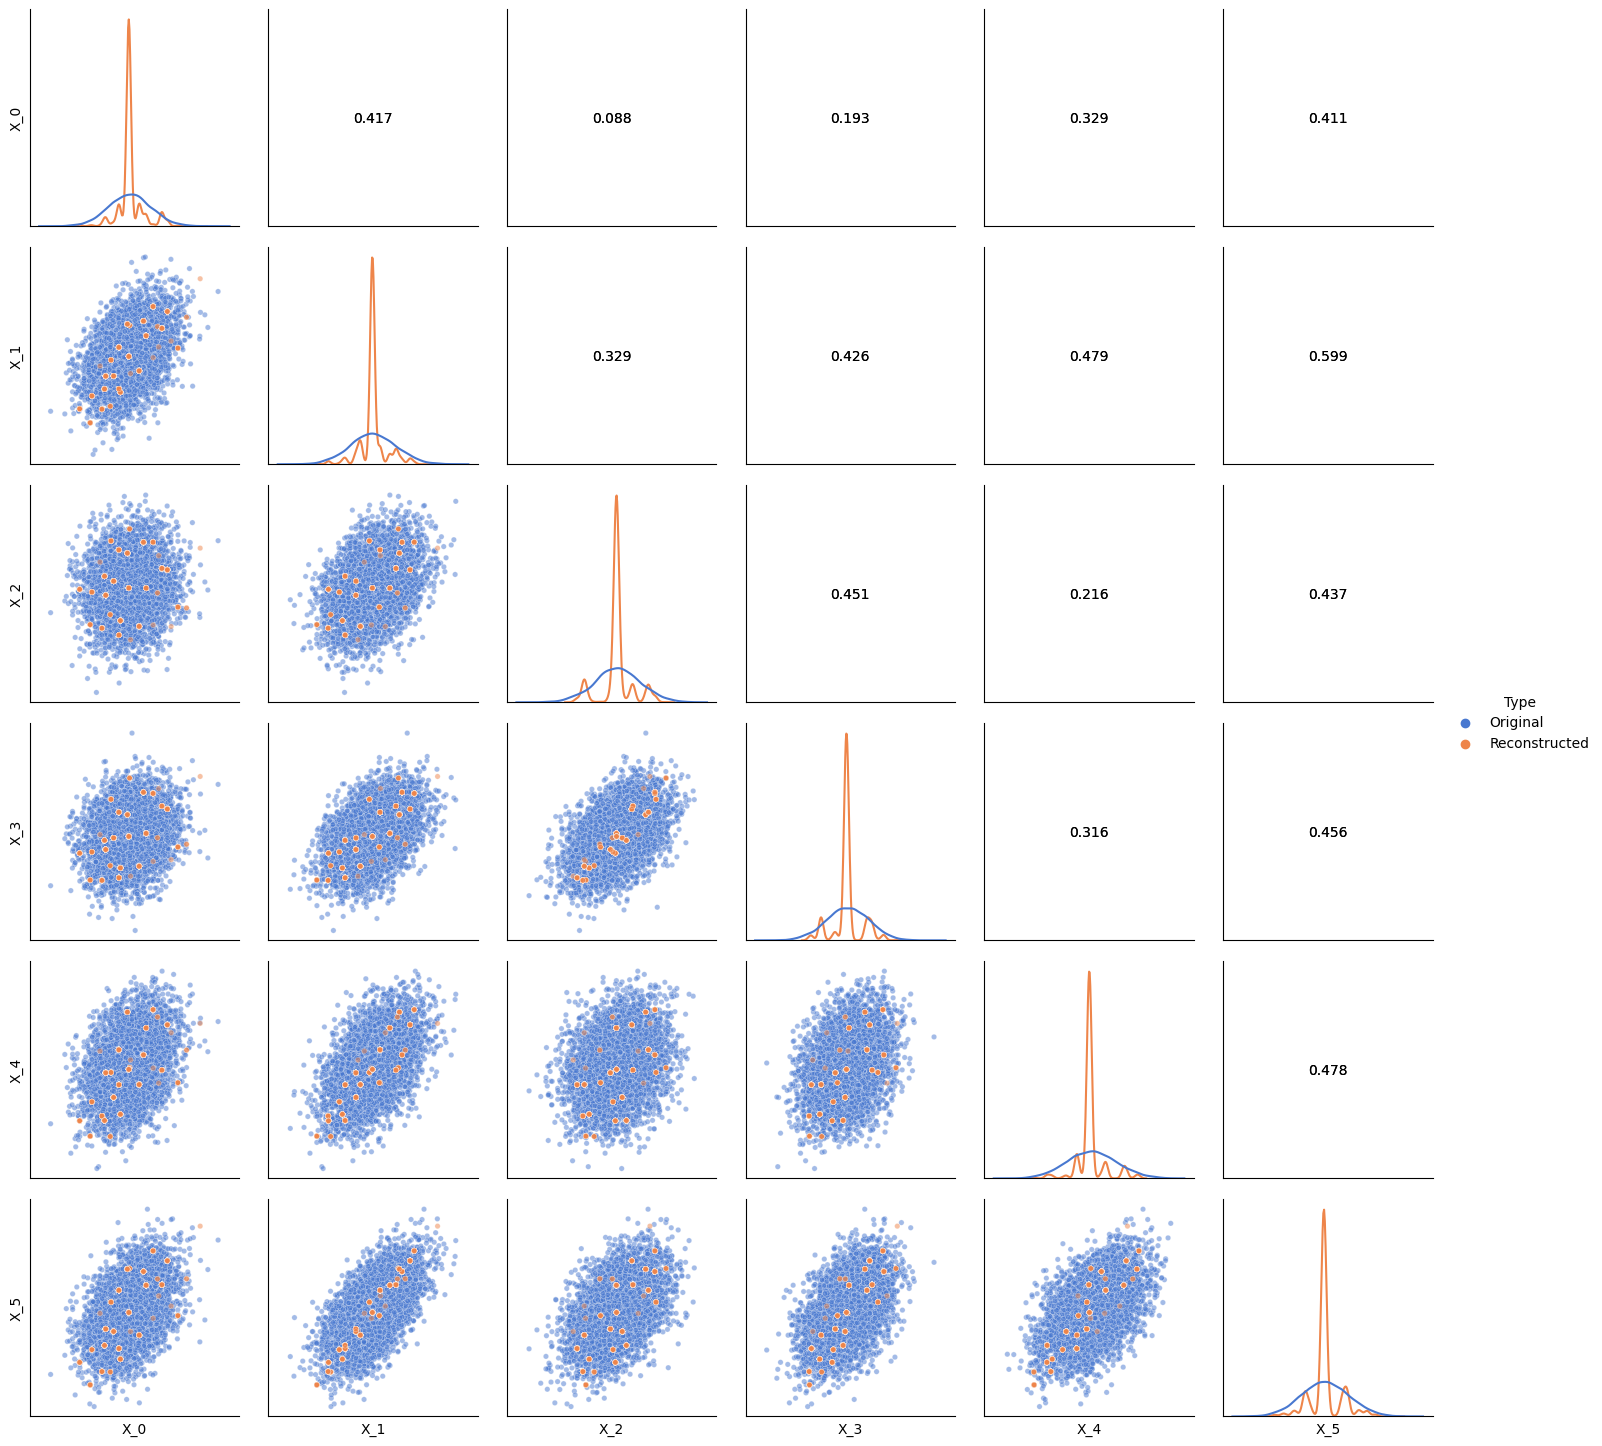

In [ ]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# kv_pair = (6,3)
kv_pair = (6,4)
# kv_pair = (9,4)

original_data = results[kv_pair][0]
reconstructed_data = results[kv_pair][1][0]
corr_matrix = results[kv_pair][2]

original_df = pd.DataFrame(original_data).add_prefix('X_')
reconstructed_df = pd.DataFrame(reconstructed_data).add_prefix('X_')

original_df['Type'] = 'Original'
reconstructed_df['Type'] = 'Reconstructed'
combined_df = pd.concat([original_df, reconstructed_df])

# Initialize the Seaborn PairGrid with a predefined color palette
g = sns.PairGrid(combined_df, hue='Type', palette='muted', diag_sharey=False)

# Map the plots to the lower, upper, and diagonal of the PairGrid
g.map_lower(sns.scatterplot, alpha=0.5, s=15)  # Scatter plot on the lower triangle
g.map_diag(sns.kdeplot)  # KDE plot on the diagonal

# Function to annotate correlation coefficient
def corrfunc(x, y, **kws):
    i = int(x.name.split('X_')[1]) 
    j = int(y.name.split('X_')[1]) 
    r = corr_matrix[i][j]
    ax = plt.gca()
    ax.annotate(f"{r:.3f}", xy=(.5, .5), xycoords=ax.transAxes,
                ha='center', va='center')

# Annotate correlation coefficient on the upper triangle
g.map_upper(corrfunc)

# Remove x and y tick marks
for ax in g.axes.flatten():
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticks([])
    ax.set_yticks([])

# Add legends
g.add_legend()
plt.show()


## PointCloud Model Outline

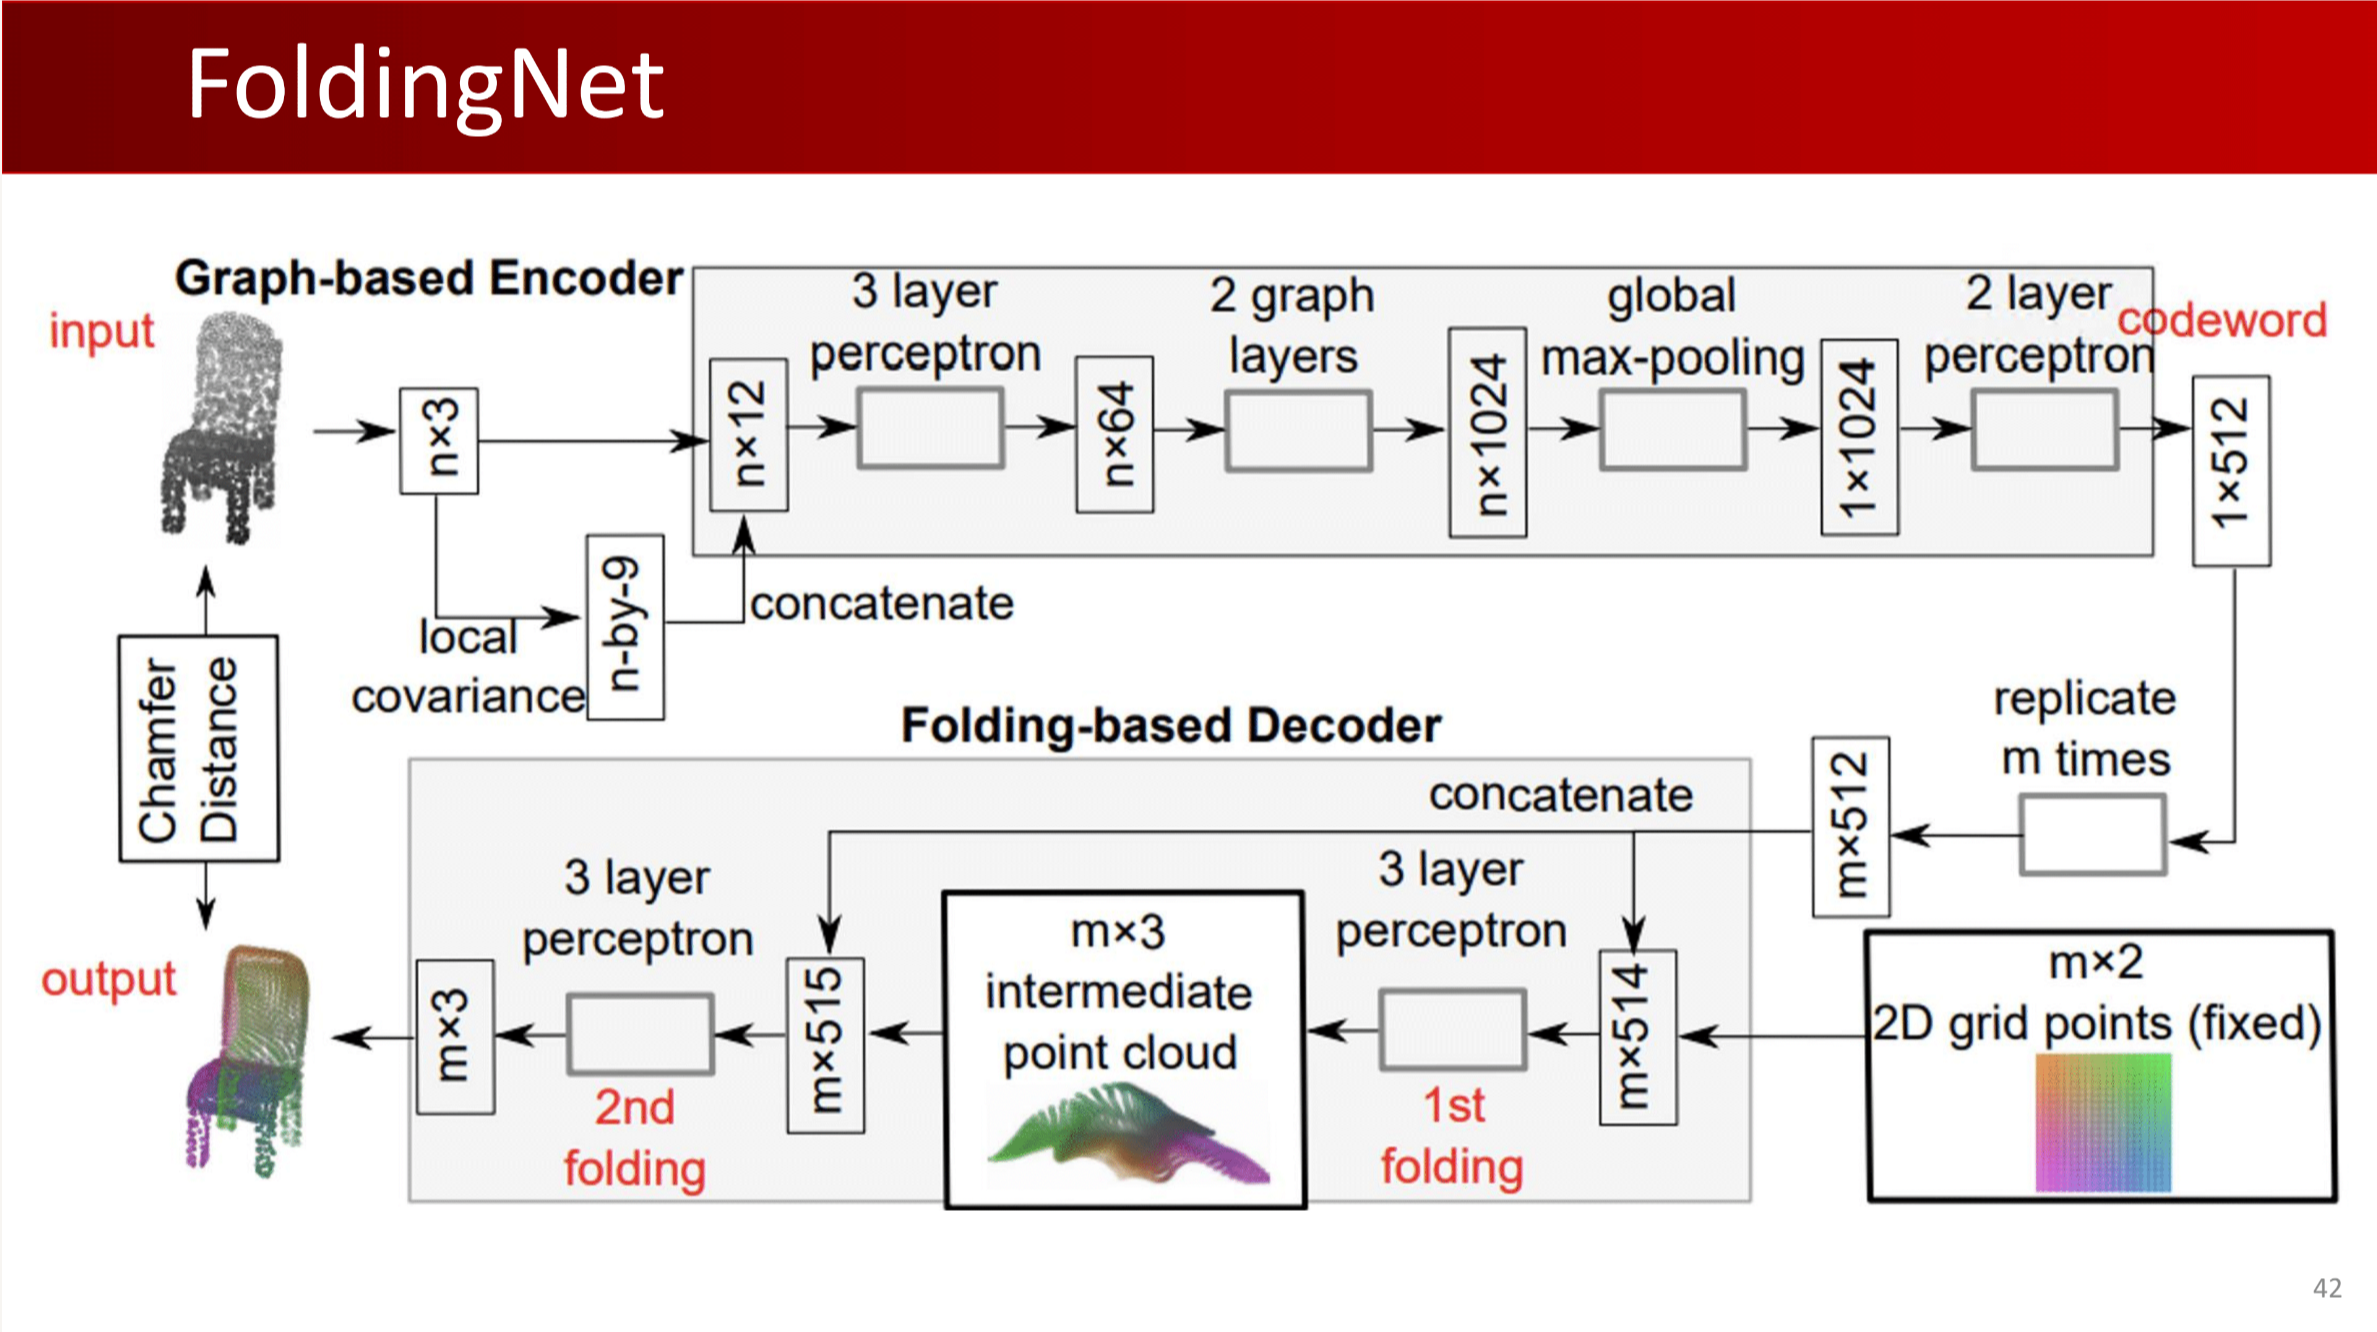

In [ ]:
from IPython.display import Image, Markdown

# PointNet Architecture
# Image(filename="/Workspace/Users/18cmn1@queensu.ca/pointnet.png") 

# FoldingNet Architecture
Image(filename="/Workspace/Users/18cmn1@queensu.ca/FoldingNet.png") 
# https://arxiv.org/pdf/1712.07262.pdf
# https://www.dropbox.com/s/eacwfrx8lvbc0er/20cs468-09-21_pointclouds.pdf?dl=0
# https://github.com/qinglew/FoldingNet

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np

def chamfer_distance(y_true, y_pred):
    # This is a placeholder and needs a proper implementation
    return tf.reduce_mean(tf.square(y_true - y_pred))



class PointCloudEncoder(tf.keras.Model):
    def __init__(self):
        super(PointCloudEncoder, self).__init__()

        # Define the layers for the encoder shown in picture above
        self.encoder_layers = [
            # layers.Dense(64, activation='relu', input_shape=(3,)),
            # layers.Dense(128, activation='relu'),
            # layers.Dense(1024, activation='relu')
        ]
    
    def call(self, inputs):
        x = inputs
        for layer in self.encoder_layers:
            x = layer(x)
        global_feature = tf.reduce_max(x, axis=1, keepdims=True) # Global feature
        return global_feature



class PointCloudDecoder(tf.keras.Model):
    def __init__(self):
        super(PointCloudDecoder, self).__init__()

        # Define the layers for the decoder shown in picture above
        self.decoder_layers = [
            # layers.Dense(64, activation='relu'),
            # layers.Dense(128, activation='relu'),
            # layers.Dense(3) # Output 3D points
        ]
    
    def call(self, codeword):
        x = codeword
        for layer in the decoder_layers:
            x = layer(x)
        return x




In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

class PointCloudCompressor:
    def __init__(self, lambda_= 0):
        self.lambda_ = lambda_
        self.optimizer = optimizers.Adam()
        self.encoder = PointCloudEncoder()
        self.decoder = PointCloudDecoder()
        self.distortion = []
        self.rate = []

    def continuous_quantizer(self, x): # Quantizer might need to change to accomadate 1 x 512 codeword
        noise = tf.random.uniform(tf.shape(x), minval=-1/2, maxval=1/2)
        return x + noise 
    
    def discrete_quantizer(self, data):
        return np.floor(data + 0.5)
    
    def lossless_coder(self, data, mu=0, sigma=1):
        mu = tf.constant(mu, dtype=tf.float32)
        sigma = tf.constant(sigma, dtype=tf.float32)
        pi = tf.constant(np.pi, dtype=tf.float32)

        return -tf.math.log((1.0 / (tf.sqrt(2.0 * pi * tf.square(sigma)))) * 
                            tf.exp(-tf.square(data - mu) / (2.0 * tf.square(sigma))))

    @tf.function
    def train_step(self, x_train):
        with tf.GradientTape() as tape:
            x_transformed = self.encoder(x_train)
            x_quantized = self.continuous_quantizer(x_transformed)
            x_hat = self.decoder(x_quantized)

            distortion = chamfer_distance(x_train, x_hat)
            rate = tf.reduce_mean(self.lossless_coder(x_quantized))

            loss = distortion + self.lambda_ * rate

        gradients = tape.gradient(loss, self.encoder.trainable_variables + self.decoder.trainable_variables)   
        self.optimizer.apply_gradients(zip(gradients, self.encoder.trainable_variables + self.decoder.trainable_variables))
        return loss
    
    def get_batches(self, data, batch_size):
        for i in range(0, len(data), batch_size):
            yield data[i:i + batch_size]

    def train(self, x_train, x_val, epochs=10, batch_size=32):

        history = {
            'loss': [],
            'val_loss': []
        }

        x_train = x_train.reshape(-1, 1).astype('float32')
        x_val = x_val.reshape(-1, 1).astype('float32')

        for epoch in range(epochs):
            train_loss = 0
            for batch in self.get_batches(x_train, batch_size):
                train_loss += self.train_step(batch).numpy()
            train_loss /= len(x_train) / batch_size
            history['loss'].append(train_loss)

            val_loss = self.evaluate(x_val)
            history['val_loss'].append(val_loss)

            print(f"Epoch {epoch+1}, Loss: {train_loss}, Validation Loss: {val_loss}")

        return history

    def evaluate(self, x_test):
        x_test = x_test.reshape(-1, 1).astype('float32')

        x_transformed = self.forward_transform(x_test)
        x_quantized = self.discrete_quantizer(x_transformed)
        x_hat = self.inverse_transform(x_quantized)
        
        distortion = tf.reduce_mean(tf.square(x_test - x_hat))
        self.distortion.append(distortion)
        
        rate = tf.reduce_mean(self.lossless_coder(x_quantized))  
        self.rate.append(rate)


        mse = distortion + self.lambda_ * rate
        return mse.numpy()

